### **A note about this document**
This is the version where I have done additional experiments after the submission. I had done the analysis using grayscale. In this version, I have done the analysis with the color images.


# **Project - Crop seedling vs Weed Differentiation using CNN**

### **Context:**
Can you differentiate a weed from a crop seedling?
The ability to do so effectively can mean better crop yields and better stewardship of the environment.
The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has
recently released a dataset containing images of unique plants belonging to 12 species at several growth stages

### **Data Description:**
You are provided with a dataset of images of plant seedlings at various stages of grown. Each image has a filename that is its
unique id. The dataset comprises 12 plant species. The goal of the project is to create a classifier capable of determining a
plant's species from a photo.

#### **Dataset:**
The dataset can be download from Olympus.
The data file names are:
* ages.npy
* Label.csv

The original files are from Kaggle. Due to the large volume of data, the images were converted to images.npy file and the labels
are also put into the Labels.csv. So that you can work on the data/project seamlessly without worrying about the high data
volume.

## **Load libraries needed for the work**

In [1]:
# Grab some of the basic libraries needed to process numbers, dataframes, and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # for data visualization 

# For preprocessing label data
from sklearn import preprocessing

# To tune model, get different metric scores and split data, and also to search for the best model using rnadomized search
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix

import cv2
from google.colab.patches import cv2_imshow

# Now the libraries to do the CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers

# Need this to plot the images
from tensorflow.keras.preprocessing import image

## **Load the data and put it in the shape we need for the analysis**

Do some data preprocessing as well to normalize the values for easier data analysis

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the images data
X = np.load('/content/drive/MyDrive/PlantData/images.npy')

In [4]:
# Load the labels for the image data
y = np.loadtxt('/content/drive/MyDrive/PlantData/Labels.csv', dtype=str, skiprows=1, delimiter='\n')

In [5]:
# Let's inspect the images data to make sure everything loaded correctly
print(X.shape)
print(X.size)

(4750, 128, 128, 3)
233472000


In [6]:
# And also look at the labels data
print(y.shape)
print(y.size)

(4750,)
4750


So there are 4750 labels.

We also expect 4750 images to be in the data.
According to the instructions, the images were reduced to 128x128 size. Since these are all color images, there are 3 channels per image. This should give us a total size of 128*128*3*4750 = 233,472,000.

This is exactly what we got when we loaded the data. So the data ha loaded correctly. The shape of X shows 4750 images of 128*128 size with 3 channels.

### **Exploratory Data Analysis**

In [7]:
# Let's create a DataFrame object for the labels and inspect the various types of labels
label_df = pd.DataFrame(y, columns=['plant'])

In [8]:
label_df.value_counts()

plant                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

The dataset is fairly balanced between the different classes of plant images that have been provided. Hence we will not need to worry about dealing with imbalances.

An inspection of the data labels shows that there are 12 distinct labels associated with the data
* Small-flowered Cranesbill
* Fat Hen
* Shepherds Purse
* Common wheat
* Common Chickweed
* Charlock
* Cleavers
* Scentless Mayweed
* Sugar beet
* Maize
* Black-grass
* Loose Silky-bent

The classifier neural network we will need to build will have 12 output neurons representing the 12 classes of data.


In [9]:
# Save away the categories. We will need them later in displaying confusion matrix
CATEGORIES = ["Small-flowered Cranesbill","Fat Hen","Shepherds Purse","Common wheat", "Common Chickweed", "Charlock", "Cleavers", "Scentless Mayweed", "Sugar beet", "Maize", "Black-grass", "Loose Silky-bent"]


In [10]:
# Let me build up an image dictionary. Essentially splitting the collection of images by classes
# in order to make it easy for me to plot images, get image means, etc.
def make_image_dict(X, y):
  image_dict = {}

  # First create empty arrays for each class of plant
  for i in range(y.size):
    image_dict[y[i]] = []

  # Now append the specific image to proper label
  for i in range(y.size):
    image_dict[y[i]].append(X[i])

  return image_dict

In [11]:
def print_image_dict(dict):
  for label in dict.keys():
    print(label, len(dict[label]))

In [12]:
# Now build the image dictionary
image_dict = make_image_dict(X, y)

# Verify that we split up the the data correctly
print_image_dict(image_dict)

Small-flowered Cranesbill 496
Fat Hen 475
Shepherds Purse 231
Common wheat 221
Common Chickweed 611
Charlock 390
Cleavers 287
Scentless Mayweed 516
Sugar beet 385
Maize 221
Black-grass 263
Loose Silky-bent 654


In [13]:
# Let me define a function to make it easy for me to display a set of images
# for the different classes of plants that are there in the data.

# I want to print 4 image from each class
def plot_plant_class(image_array, label):
  # Prepare to plot images in 16x16 pixels
  fig = plt.figure(figsize = (16,16))

  # Display 12 randomly selected images
  maximum = 4
  selected_idx = np.random.choice(len(image_array), size=maximum, replace = False)
  print(selected_idx)

  for i in range(maximum):
    ax = fig.add_subplot(1, maximum, i+1)

    plt.imshow(image_array[selected_idx[i]], cmap='Greys_r')  # The cmap is ignored for RGB images
    plt.title(label)
    plt.axis('off')
  plt.show()

[198 184 144 200]


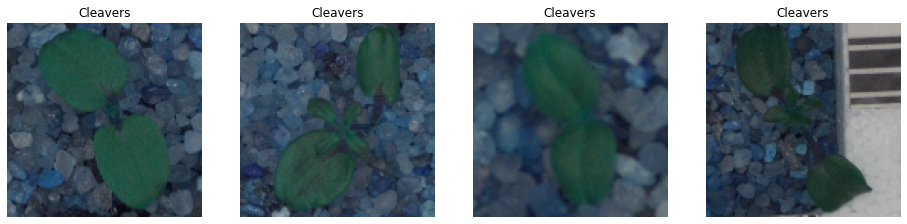

In [14]:
# This is just a small test to make sure that I am able to display an image class correctly.
def test_plot_plant_class(image_dict):
  label = "Cleavers"
  plot_plant_class(image_dict[label], label)

test_plot_plant_class(image_dict)

In [15]:
# Let me define a function to make it easy for me to display a set of images
# for the different classes of plants that are there in the data.

# We have 12 classes of data. I want to print a row of images per class
def plot_plant_classes(image_dict):
  for label in image_dict.keys():
    plot_plant_class(image_dict[label], label)

[344 115 240 247]


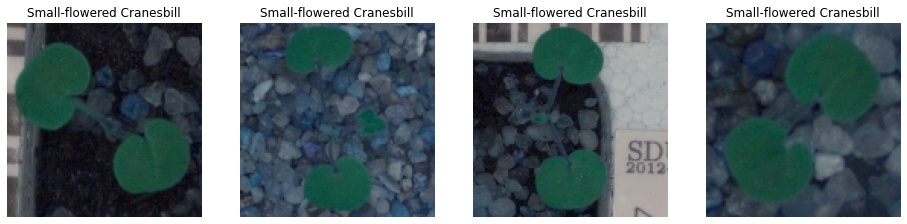

[377   6 122 204]


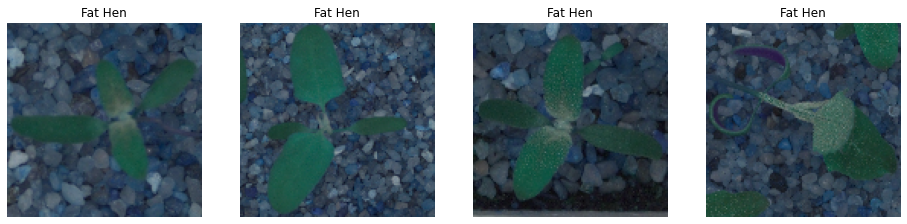

[ 58  10 112 127]


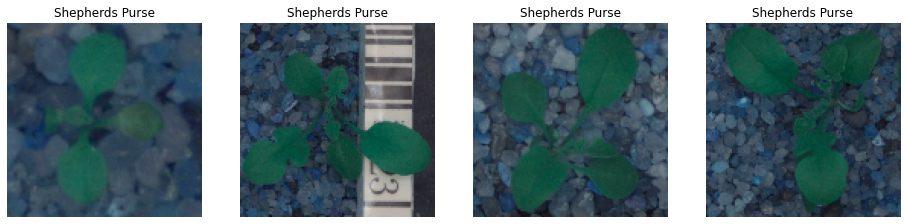

[ 31 190  81 157]


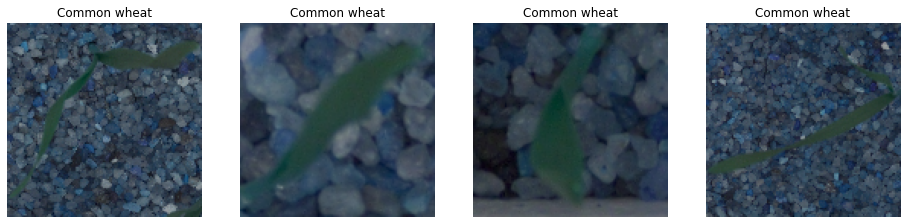

[264 531 477  71]


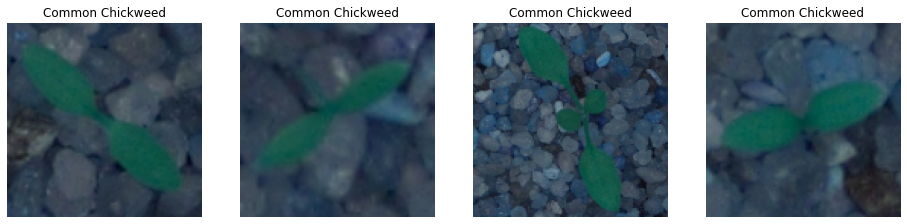

[112 116 327 137]


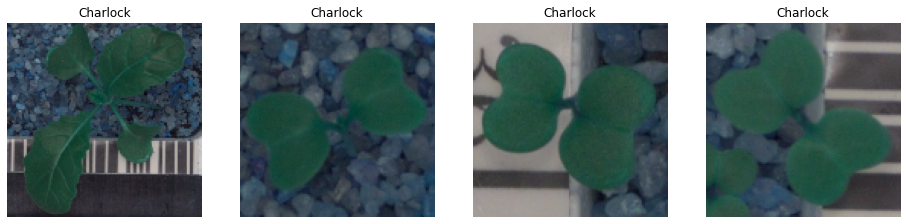

[142  23  11  41]


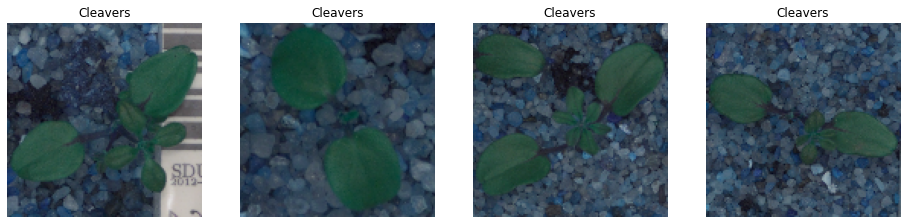

[383 100 133 179]


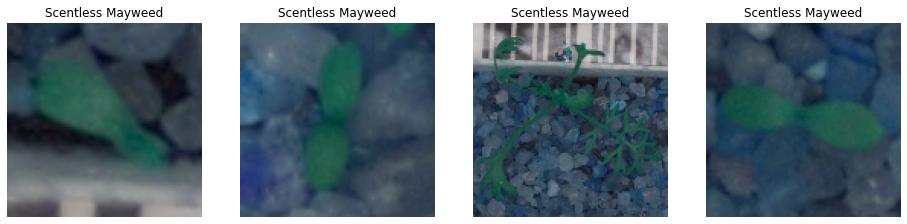

[ 85 384 337 380]


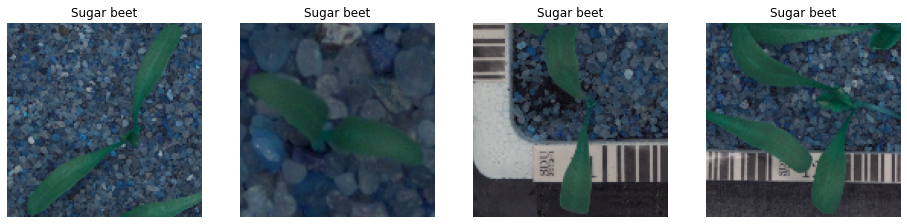

[102  65   9 168]


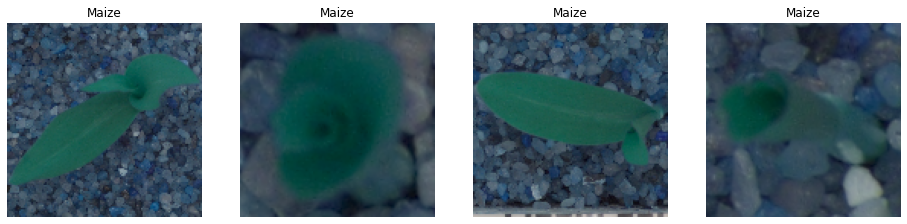

[198 167  80 251]


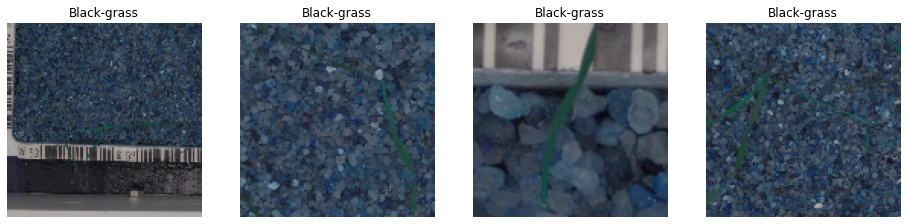

[ 66 186 321 358]


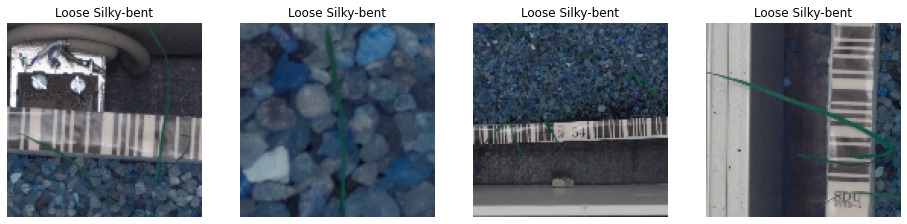

In [16]:
# Plot the different types of plants
plot_plant_classes(image_dict)

In [17]:
# Let me define a function to calculate the mean image for an array if images (assumed to be of the same class)
# TODO: Calculating the image average will need some work, so skipping over this for now.
def find_mean_image(image_array):
    # Start by flattening the image data into a flat array
    full_mat = np.array(image_array)

    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)

    # reshape it back to a matrix
    mean_img = mean_img.reshape((128,128,3))
    return mean_img

In [18]:
# Let me define a function that makes it easy to calculate mean images and to plot them.
# We have 12 classes of plants. Display in a 4x3 grid.

def plot_plant_mean_images(image_dict):
  mean_image_dict = {}

  # Prepare to plot images in 16x16 pixels
  fig = plt.figure(figsize = (16,16))

  i=0
  for label in image_dict.keys():
    ax = fig.add_subplot(4, 3, i+1)
    i = i + 1

    mean_image_dict[label] = find_mean_image(image_dict[label])

    # Display the image for each category
    plt.imshow(mean_image_dict[label], vmin=0, vmax=255, cmap='Greys_r')
    plt.title('Average ' + label)
    plt.axis('off')
  plt.show()

  return mean_image_dict

In [19]:
# Plot all the mean images for each of the classes
# TODO: Turn on plotting of image means when I have figure out how to properly calculate image means
#mean_image_dict = plot_plant_mean_images(image_dict)

The mean image doesn't look very interesting as everything appears to have blended into a mashup of everything.

### **EDA Summary**

I see that
* Data is fairly balanced between the different classes if images that have been provided.
* This will make it easier to deal with analysis as we can use accuracy as a measure for identifying effectiveness of model. We will not necessarily need to look at recall.
* The mean images do not provide any meaningful data as the images are all in slightly different angles. As a result, the mean image has become a mashup of all the images and does not show any specific trend. I expect that this will make it difficult to get very accurate results from the CNN model.

### **Data Pre-processing**

In [20]:
# In order to remove sharp edges, I am now going to apply a gaussian blurring to the images
for i in range(len(y)):
  X[i] = cv2.GaussianBlur(X[i], (5, 5), 0)

[350 307 112  11]


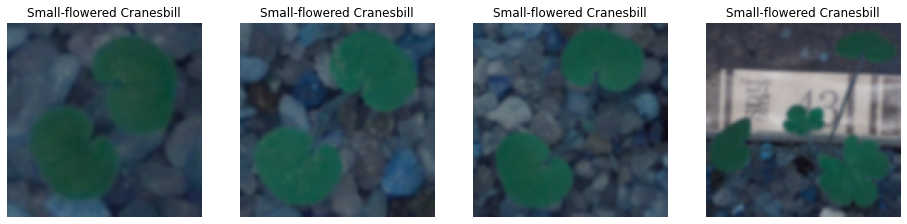

[352 383 229 425]


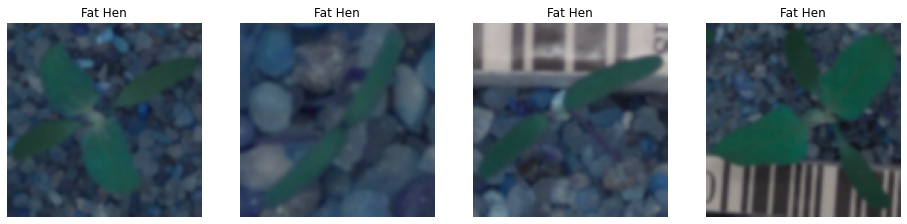

[ 84 170 161 205]


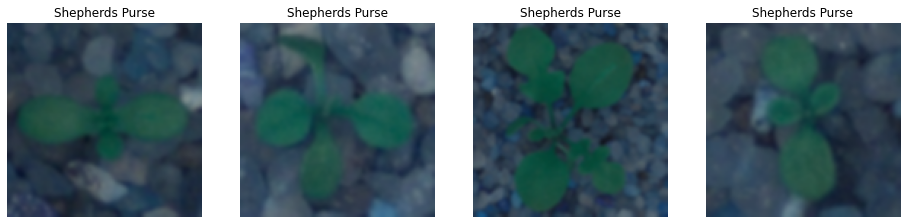

[ 44 219 181 196]


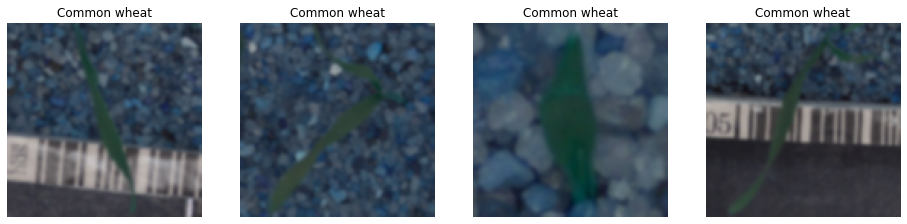

[208  19 558 297]


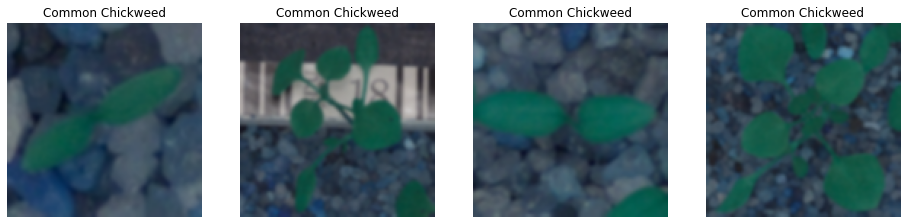

[149 216 278 118]


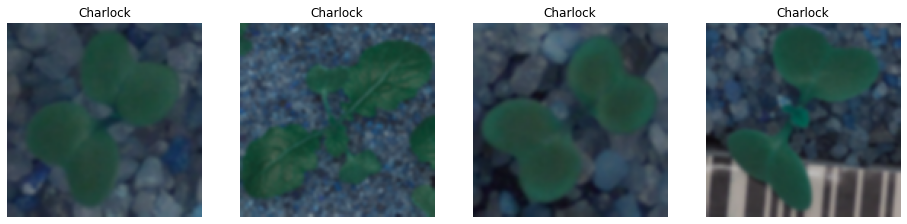

[246 210 150 236]


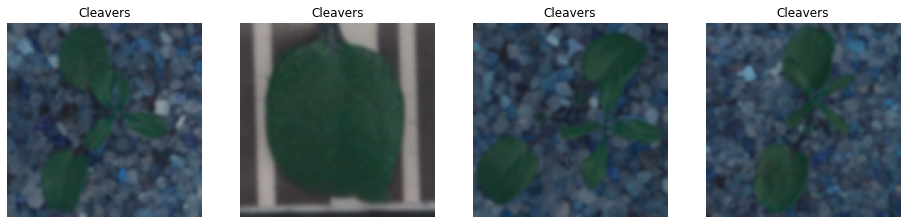

[299 352  26 221]


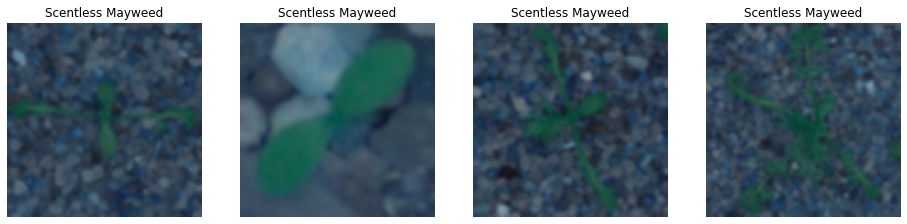

[ 85  88 295  44]


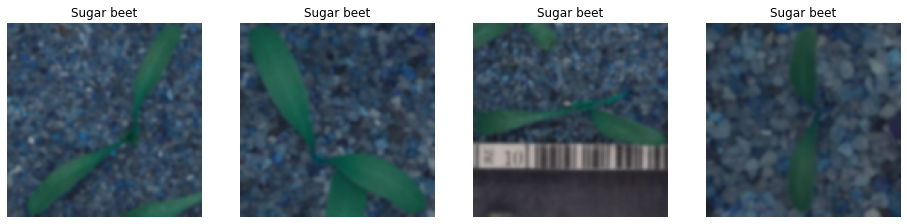

[177  77 168 102]


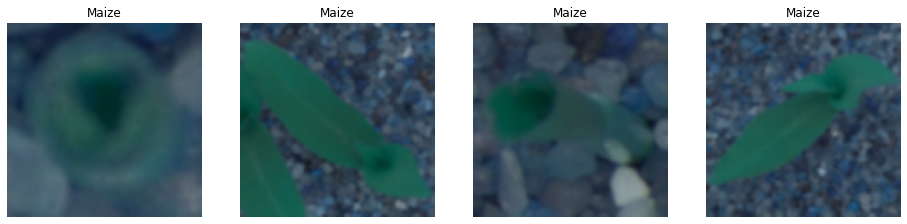

[186 104  33 214]


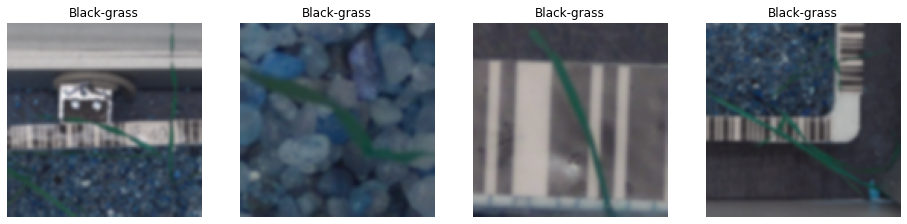

[539 126 579 454]


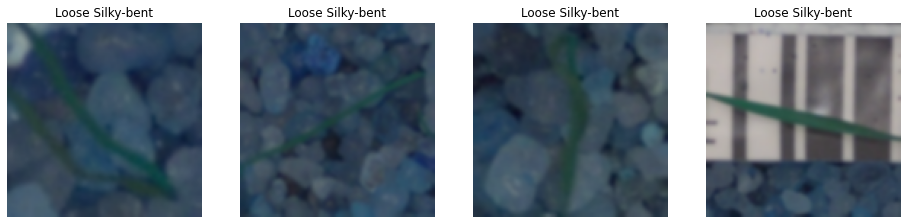

In [21]:
# Display the blurred image
image_dict = make_image_dict(X, y)

plot_plant_classes(image_dict)

In [27]:
def normalize_image(X):
  print("Before:", X[0][0][0])
  X = X.reshape(-1,1)
  print(X.shape)
  normX = X/255.0  
  normX = normX.reshape(-1,128,128,3)
  print(normX.shape)
  print("After:", normX[0][0][0])
  return normX

In [30]:
# Let's normalize the data
normX = normalize_image(X)

Before: [36 51 74]
(233472000, 1)
(4750, 128, 128, 3)
After: [0.14117647 0.2        0.29019608]


### **Time to split the data into train and test**

In [31]:
# Split data into train, and test. There is no need to separate the train data into train and validation
# as this can be done directly using Keras.
X_train, X_test, y_train, y_test = train_test_split(
    normX, y, test_size=0.2, random_state=1, stratify=y
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3800, 128, 128, 3) (950, 128, 128, 3)
(3800,) (950,)


### **One-hot encoding for the labels**

The labels are all in strings. We need to one-hot encode them because the data needs to be in a format required by keras

In [32]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()   # Need encoder to convert from the string to numbers

In [33]:
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_train_enc = to_categorical(y_train)

In [34]:
encoder.fit(y_test)
y_test = encoder.transform(y_test)
y_test_enc = to_categorical(y_test)

In [97]:
# Verify that the encoding happened correctly
print(y_train_enc.shape, y_test_enc.shape)
print(y_train[0], y_test[0])
print(y_train_enc[0], y_test_enc[0])

(3800, 12) (950, 12)
6 10
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


### **Model Building**

First let me create a reusable function that I can use to plot accuracy histiry during training

In [36]:
def plot_training_history(history):
  print(history.history.keys())
  
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


#### To simplify the model creation , I am going to take advantage of some code that was used in MLS class to define a class, which makes it easy to set up a new CNN model. Code here is adapted from class.

In [37]:
# This class represents input layer or a convolution layer
class conv_Layers:

  def __init__(self, nfilters, kernel_size, stride=1, 
               pool_size=2, leakyrelu_slope=0.1, dropc=0.0, bnorm=False):
    self.nfilters = nfilters
    self.kernel_size = kernel_size
    self.stride = stride
    self.pool_size = pool_size
    self.leakyrelu_slope = leakyrelu_slope
    self.dropfrac = dropc
    self.bnorm = bnorm
  
  def __call__(self, x):
    x = Conv2D(self.nfilters, kernel_size=self.kernel_size, 
               strides=self.stride, padding='same')(x)
    x = LeakyReLU(self.leakyrelu_slope)(x)
    if (self.dropfrac > 0.0): 
      x = Dropout(self.dropfrac)(x)
    if (self.bnorm):
      x = BatchNormalization()(x)
    x = MaxPool2D(self.pool_size)(x)
    return x

# This class represents a Dense layer
class dense_Layers:

  def __init__(self, nunits, leakyrelu_slope=0.1, dropd=0.0, bnorm=False):
    self.nunits = nunits
    self.leakyrelu_slope = leakyrelu_slope 
    self.dropfrac = dropd
    self.bnorm = bnorm

  def __call__(self, x):
    x = Dense(self.nunits)(x)
    x = LeakyReLU(self.leakyrelu_slope)(x)
    if (self.dropfrac > 0.0):
      x = Dropout(self.dropfrac)(x)
    if (self.bnorm):
      x = BatchNormalization()(x)
    return x

# The constructor here sets up multiple hidden layers, a Flatten layer, and finally
# a Dense layer to handle the output.
def LNmodel(in_shape, conv_filters, dense_filters, kernel_size, num_classes, lr,
            stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.0, dropd=0.0, bnorm=False):

  in_shape = X_train.shape[1:]
  i = Input(shape=in_shape)
  for ncl, nconvfilters in enumerate(conv_filters):
    if (ncl==0):
      x = conv_Layers(nconvfilters, kernel_size,
                      stride, pool_size, leakyrelu_slope, dropc, bnorm)(i)
    else:
      x = conv_Layers(nconvfilters, kernel_size,
                      stride, pool_size, leakyrelu_slope, dropc, bnorm)(x)

  x = Flatten()(x)

  for ndl, ndunits in enumerate(dense_filters):
    x = dense_Layers(ndunits, leakyrelu_slope, dropd, bnorm)(x)

  x = Dense(num_classes, activation='softmax')(x)

  ln_model  = Model(inputs=i, outputs=x)
  adam = optimizers.Adam(learning_rate=lr)
  ln_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  return ln_model

#### **Model 1:** CNN with Dropout

The logic for building the model has been picked up from examples discussed in MLS session.

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model = Sequential()

# Input layer with 64 filters, kernel of 5x5, followed by pooling using Max pool strategy
#y_train_enc=np.array(y_train_enc)
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Hidden layer #1 with 128 filters, kernel size of 3x3, followed by pooling using Max pool strategy 
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Hidden layer #2 with 128 filters, kernel size of 3x3, followed by pooling using Max pool strategy
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

# Hidden layer #3 with 128 filters, kernel size of 2x2, followed by pooling using Max pool strategy
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

# Hidden layer #4 with 256 filters, kernel size of 2x2, followed by pooling using Max pool strategy
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

# Hidden layer #5
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))

# Output layer with 12 neurons for the 12 output classes
model.add(Dense(12, activation = "softmax"))
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 200  
batch_size = 64

In [39]:
# Fit the model on the training data

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit(X_train, 
          y_train_enc,  #It expects integers because of the sparse_categorical_crossentropy loss function
          epochs=30, #number of iterations over the entire dataset to train on
          batch_size=64,validation_split=0.20,callbacks=[es, mc],use_multiprocessing=True)#number of samples per gradient update for training  

Epoch 1/30
48/48 [==============================] - 20s 70ms/step - loss: 2.4459 - accuracy: 0.1309 - val_loss: 2.4041 - val_accuracy: 0.1408

Epoch 00001: val_accuracy improved from -inf to 0.14079, saving model to best_model.h5
Epoch 2/30
48/48 [==============================] - 2s 47ms/step - loss: 2.4260 - accuracy: 0.1270 - val_loss: 2.4015 - val_accuracy: 0.1408

Epoch 00002: val_accuracy did not improve from 0.14079
Epoch 3/30
48/48 [==============================] - 2s 46ms/step - loss: 2.2391 - accuracy: 0.2441 - val_loss: 1.7935 - val_accuracy: 0.4158

Epoch 00003: val_accuracy improved from 0.14079 to 0.41579, saving model to best_model.h5
Epoch 4/30
48/48 [==============================] - 2s 47ms/step - loss: 1.7860 - accuracy: 0.3658 - val_loss: 1.6693 - val_accuracy: 0.4382

Epoch 00004: val_accuracy improved from 0.41579 to 0.43816, saving model to best_model.h5
Epoch 5/30
48/48 [==============================] - 2s 46ms/step - loss: 1.6104 - accuracy: 0.4266 - val_loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


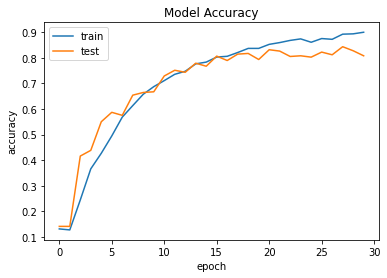

In [40]:
# Let's see the history of the run
plot_training_history(history)

The model is slightly overfitting the training data.

#### **Model 2**

In this model, I am using a much smaller number of filters in the convolution layer as well as in the dense layers.

In [41]:
lr = 0.001
kernelsize = 5
in_shape= X_train.shape[1:]
model_ln2 = LNmodel(in_shape, [8,16], [16,8], kernelsize, 12, lr,
                    stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.25,
                    dropd=0.5, bnorm=False)
model_ln2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 8)       608       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 8)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 16)        3216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 16)        0     

In [42]:
# Train this new model on the training data, and validate by splitting off data into a validation set
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# This time we will use a bigger batch size and also run through more number of epochs
history_model_ln2 = model_ln2.fit(X_train, y_train_enc, 
                                  validation_split=0.1,
                                  verbose=1, batch_size=256,
                                  shuffle=True, epochs=60,callbacks=[es,mc])

Epoch 1/60
14/14 [==============================] - 2s 84ms/step - loss: 2.5028 - accuracy: 0.1018 - val_loss: 2.4722 - val_accuracy: 0.1211

Epoch 00001: val_accuracy improved from -inf to 0.12105, saving model to best_model.h5
Epoch 2/60
14/14 [==============================] - 1s 59ms/step - loss: 2.4758 - accuracy: 0.1108 - val_loss: 2.4660 - val_accuracy: 0.1211

Epoch 00002: val_accuracy did not improve from 0.12105
Epoch 3/60
14/14 [==============================] - 1s 58ms/step - loss: 2.4674 - accuracy: 0.1135 - val_loss: 2.4604 - val_accuracy: 0.1237

Epoch 00003: val_accuracy improved from 0.12105 to 0.12368, saving model to best_model.h5
Epoch 4/60
14/14 [==============================] - 1s 57ms/step - loss: 2.4550 - accuracy: 0.1310 - val_loss: 2.4186 - val_accuracy: 0.1368

Epoch 00004: val_accuracy improved from 0.12368 to 0.13684, saving model to best_model.h5
Epoch 5/60
14/14 [==============================] - 1s 58ms/step - loss: 2.4027 - accuracy: 0.1538 - val_loss:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


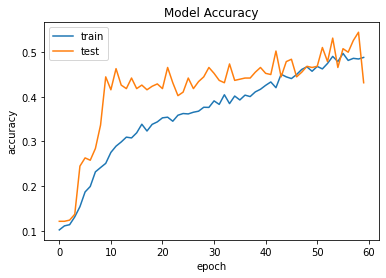

In [43]:
# Plot the training history for this run
plot_training_history(history_model_ln2)

This model is not overfitting the training data. However, the model's accuracy is not very high. It appears that while having a smaller number of convilution filters and dense filters is faster, it is not sufficient to capture the rich number of features in the data.

### **Model 3**

This model has the same number of 8 & 16 filters for the convolution filters, but it has a much larger (512 and 256) number of filters for the dense layers.

In [44]:
lr = 0.001
kernelsize = 5
model_ln3 = LNmodel(in_shape, [8,16], [512,256], kernelsize, 12, lr,
                    stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.25,
                    dropd=0.5, bnorm=False)
model_ln3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 8)       608       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 128, 8)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        3216      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 16)        0   

In [45]:
# Let's train this data on the training set (that is split internally into train/validation)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history_model_ln3 = model_ln3.fit(X_train, y_train_enc, 
                                  validation_split=0.1,
                                  verbose=1, batch_size=512, 
                                  shuffle=True, epochs=40,callbacks=[es,mc])

Epoch 1/40
7/7 [==============================] - 2s 211ms/step - loss: 2.7310 - accuracy: 0.1003 - val_loss: 2.4646 - val_accuracy: 0.2132

Epoch 00001: val_accuracy improved from -inf to 0.21316, saving model to best_model.h5
Epoch 2/40
7/7 [==============================] - 1s 118ms/step - loss: 2.4255 - accuracy: 0.1336 - val_loss: 2.3649 - val_accuracy: 0.1632

Epoch 00002: val_accuracy did not improve from 0.21316
Epoch 3/40
7/7 [==============================] - 1s 115ms/step - loss: 2.3593 - accuracy: 0.1860 - val_loss: 2.2872 - val_accuracy: 0.2263

Epoch 00003: val_accuracy improved from 0.21316 to 0.22632, saving model to best_model.h5
Epoch 4/40
7/7 [==============================] - 1s 116ms/step - loss: 2.2659 - accuracy: 0.2108 - val_loss: 2.1696 - val_accuracy: 0.2684

Epoch 00004: val_accuracy improved from 0.22632 to 0.26842, saving model to best_model.h5
Epoch 5/40
7/7 [==============================] - 1s 117ms/step - loss: 2.1815 - accuracy: 0.2357 - val_loss: 2.13

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


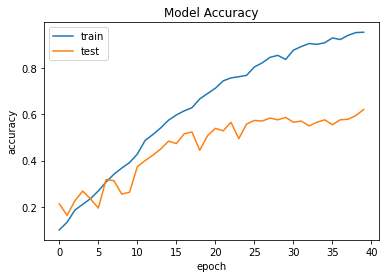

In [46]:
# Plot the training history for this run
plot_training_history(history_model_ln3)

This is a case of extreme overfitting of the training data with poor performance with the validation set.

### **Model 4**

This time I am going to try assigning a larger number of filters in the convolution layers.

I am going to decrease the number of filters in the dense layer as I saw that there was a lot of overfitting when there were a large number of filters in the dense layer.

I will also try using a smaller kernel.

In [81]:
lr = 0.001
kernelsize = 3
model_ln4 = LNmodel(in_shape, [32,32], [64,64], kernelsize, 12, lr,
                    stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.25,
                    dropd=0.5, bnorm=False)
model_ln4.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 64, 64, 32)        0  

In [82]:
# Let's train this data on the training set (that is split internally into train/validation)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history_model_ln4 = model_ln4.fit(X_train, y_train_enc, 
                                  validation_split=0.1,
                                  verbose=1, batch_size=512, 
                                  shuffle=True, epochs=40,callbacks=[es,mc])

Epoch 1/40
7/7 [==============================] - 2s 207ms/step - loss: 2.7065 - accuracy: 0.0930 - val_loss: 2.4690 - val_accuracy: 0.1079

Epoch 00001: val_accuracy improved from -inf to 0.10789, saving model to best_model.h5
Epoch 2/40
7/7 [==============================] - 1s 164ms/step - loss: 2.4580 - accuracy: 0.1211 - val_loss: 2.4139 - val_accuracy: 0.1816

Epoch 00002: val_accuracy improved from 0.10789 to 0.18158, saving model to best_model.h5
Epoch 3/40
7/7 [==============================] - 1s 163ms/step - loss: 2.4026 - accuracy: 0.1602 - val_loss: 2.3497 - val_accuracy: 0.1368

Epoch 00003: val_accuracy did not improve from 0.18158
Epoch 4/40
7/7 [==============================] - 1s 163ms/step - loss: 2.2897 - accuracy: 0.2322 - val_loss: 2.1684 - val_accuracy: 0.3974

Epoch 00004: val_accuracy improved from 0.18158 to 0.39737, saving model to best_model.h5
Epoch 5/40
7/7 [==============================] - 1s 164ms/step - loss: 2.1982 - accuracy: 0.2807 - val_loss: 2.03

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


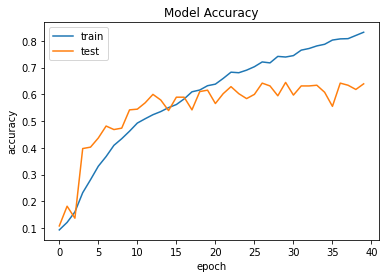

In [83]:
# Plot the training history for this run
plot_training_history(history_model_ln4)

This is not a good model. There is overfitting of data, and there isn't a lot of consistency in testing with the validation data.

### **Model Evaluation**

#### **Model 1**

In [57]:
# Let's just run it on the test set, although the model is not really suitable for production
model.evaluate(X_test,np.array(y_test_enc))

30/30 [==============================] - 0s 15ms/step - loss: 0.7067 - accuracy: 0.7863


[0.7067292928695679, 0.7863157987594604]

We got a fairly good accuracy of 78.63% with the first model.

#### **Model 2**

In [58]:
# Again, let's run this model through the test set, although our validation results show that accuracy is quite poor
model_ln2.evaluate(X_test,np.array(y_test_enc))

30/30 [==============================] - 0s 7ms/step - loss: 1.7650 - accuracy: 0.4105


[1.7650208473205566, 0.410526305437088]

This is a lot less accurate model, resulting in only 41% accuracy with the test data.

#### **Model 3**


In [59]:
# Again, let's run this model through the test set, although our validation results show that accuracy is quite poor
model_ln3.evaluate(X_test,np.array(y_test_enc))

30/30 [==============================] - 0s 6ms/step - loss: 1.4651 - accuracy: 0.6211


[1.4650765657424927, 0.621052622795105]

This is a better model with 62.1% accuracy with the test data.

#### **Model 4**

In [84]:
# Again, let's run this model through the test set, although our validation results show that accuracy is quite poor
model_ln4.evaluate(X_test,np.array(y_test_enc))

30/30 [==============================] - 0s 8ms/step - loss: 1.0760 - accuracy: 0.6568


[1.0759817361831665, 0.6568421125411987]

This model has a slightly better accuracy than model 3, giving us a 65.6% accuracy.

### **Plot Confusion Matrix for the Models**

### **Model 1**

In [85]:
# Test Prediction 
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_pred_prob = np.max(y_test_pred, axis=1)

In [86]:
# Test Accuracy 
accuracy_score(np.array(y_test), y_test_pred_classes)

0.7863157894736842

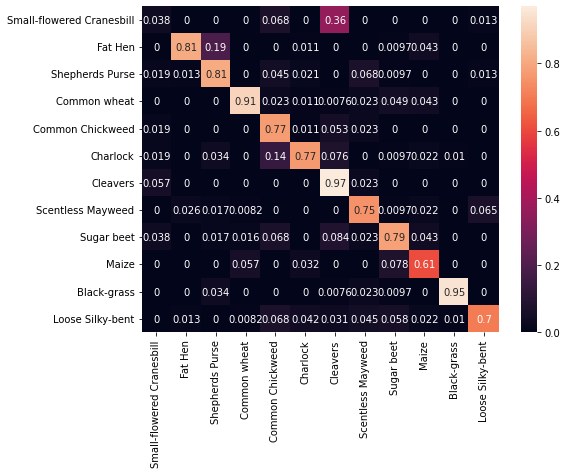

In [87]:
cf_matrix = confusion_matrix(np.array(y_test), y_test_pred_classes)

# Confusion matrix normalized per category true value
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)

This is quite a good model and has pretty high accuracy rates for all of the different plants and weeds, except for the Small-flowered Cranebill.

### **Model 2**

In [88]:
# Test Prediction 
y_test_pred_ln2 = model_ln2.predict(X_test)
y_test_pred_classes_ln2 = np.argmax(y_test_pred_ln2, axis=1)
y_test_pred_prob_ln2 = np.max(y_test_pred_ln2, axis=1)

In [89]:
# Test Accuracy 
accuracy_score(np.array(y_test), y_test_pred_classes_ln2)

0.4105263157894737

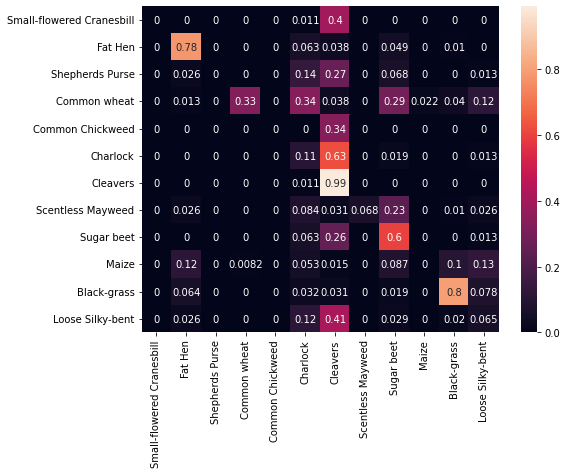

In [90]:
cf_matrix = confusion_matrix(np.array(y_test), y_test_pred_classes_ln2)

# Confusion matrix normalized per category true value
cf_matrix_n2 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix_n2, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)

This model can only predict 4 out of 12 classes of plants with an accpetable accuracy rate. This is not a good model to use.

### **Model 3**

In [91]:
# Test Prediction 
y_test_pred_ln3 = model_ln3.predict(X_test)
y_test_pred_classes_ln3 = np.argmax(y_test_pred_ln3, axis=1)
y_test_pred_prob_ln3 = np.max(y_test_pred_ln3, axis=1)

In [92]:
# Test Accuracy 
accuracy_score(np.array(y_test), y_test_pred_classes_ln3)

0.6210526315789474

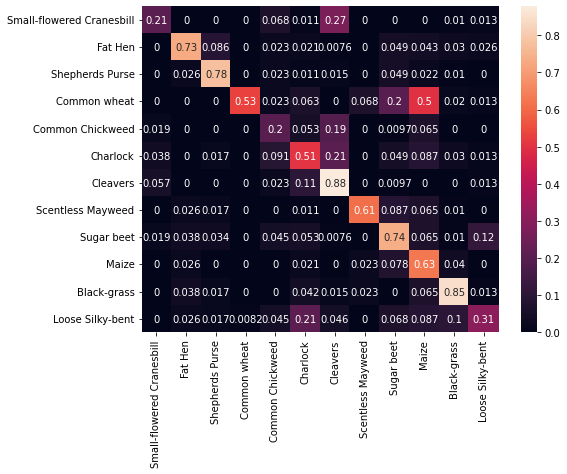

In [93]:
cf_matrix = confusion_matrix(np.array(y_test), y_test_pred_classes_ln3)

# Confusion matrix normalized per category true value
cf_matrix_n3 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix_n3, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)

This appears to be the best model of the four models I did. The bias is towards identifying images as Common Wheat or Sugar Beet.

While this is still not an acceptable model, it is able to identify Common Wheat with 57% accuracy and it can identify Sugar Beet with 49% accuracy.

#### **Model 4**

In [94]:
# Test Prediction 
y_test_pred_ln4 = model_ln4.predict(X_test)
y_test_pred_classes_ln4 = np.argmax(y_test_pred_ln4, axis=1)
y_test_pred_prob_ln4 = np.max(y_test_pred_ln4, axis=1)

In [95]:
# Test Accuracy 
accuracy_score(np.array(y_test), y_test_pred_classes_ln4)

0.6568421052631579

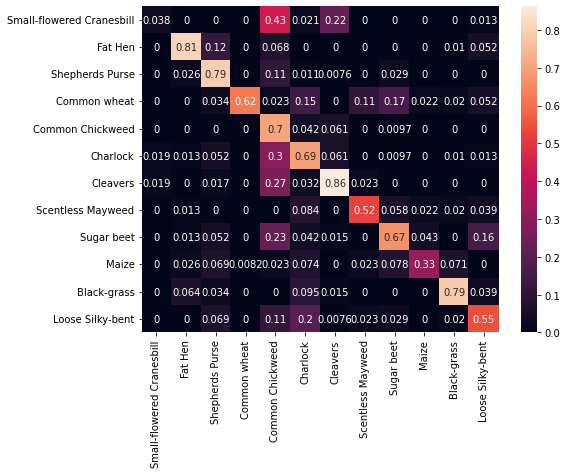

In [96]:
cf_matrix = confusion_matrix(np.array(y_test), y_test_pred_classes_ln4)

# Confusion matrix normalized per category true value
cf_matrix_n4 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix_n4, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)

The confusion matrix shows that the model is working quite well for 10 out of 12 categories. The accuracy for Small-flowered Cranebill is close to 0. Also, accuracy for Maize is also fairly low at 33%. But for the rest of the classes, the accuracy is quite good.

### **Model Selection**

The best model out of the four is Model #1. I will use this model to test some predictions.

### **Predictions**

In [98]:
def getLabelAsText(outcome):
  predicted = np.argmax(outcome)
  return CATEGORIES[predicted]

In [105]:
def showSingleImage(data, label):
  plt.imshow(data, cmap='Greys_r')  # cmap is ignored for RGB data
  plt.title(label)
  plt.axis('off')
  plt.show()

[572 249 916  80 776 136 932 680 740 669]


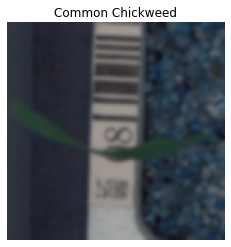

Predicted by model as Cleavers


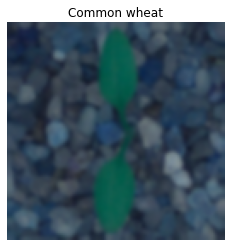

Predicted by model as Common wheat


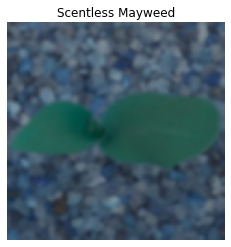

Predicted by model as Loose Silky-bent


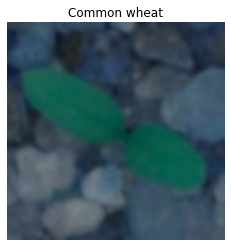

Predicted by model as Common wheat


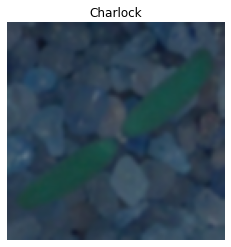

Predicted by model as Charlock


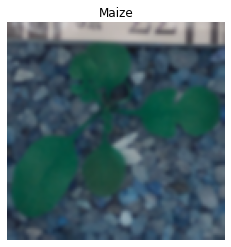

Predicted by model as Maize


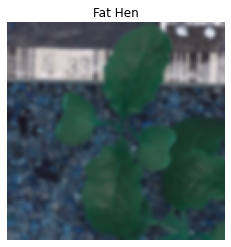

Predicted by model as Fat Hen


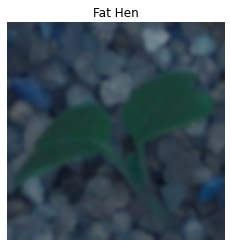

Predicted by model as Shepherds Purse


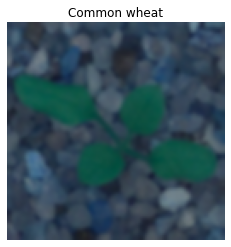

Predicted by model as Common wheat


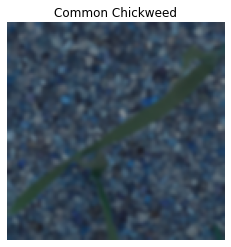

Predicted by model as Common Chickweed


In [117]:
# Let us try some random test data
test_indices = np.random.choice(len(X_test), 10, replace=False)
print(test_indices)
for idx in test_indices:
  showSingleImage(X_test[idx], getLabelAsText(y_test_enc[idx]))
  res=model.predict(X_test[idx].reshape(1,128,128,3))
  print("Predicted by model as " + getLabelAsText(res))

### **Summary and Analysis**

The model #1 is giving us some excellent accuracy with recognizing the various plants, as demonstrated in some of the spot-check tests.

The results have been quite good even without converting the images into grayscale. That means that the model works quite well even with full RGB.

The mistake I had made with the project submission was that the normalization had not happened correctly, hence the data was not within the 0-1 range and that had caused the poor performance with model predictions.